In [3]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-07-06 14:55:40,502: Credentials are already in use. The existing account in the session will be replaced.


In [4]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import Qiskit classes
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

In [5]:
#Number of qubits
nQ = 3
#There are 3 qubits: Q0,Q1,Q2.
#Number of seeds (random sequences)
nseeds = 5
#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = np.arange(1,200,20)
#2Q RB on Q0,Q2 and 1Q RB on Q1
rb_pattern = [[0,2],[1]]
#Do three times as many 1Q Cliffords
length_multiplier = [1,3]

In [6]:
rb_opts = {}
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_opts['length_multiplier'] = length_multiplier
rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

In [7]:
print(rb_circs[0][0])

      ┌─────┐┌───┐               ┌─────┐┌───┐        ┌───┐┌───┐      ░ ┌─────┐»
qr_0: ┤ Sdg ├┤ H ├────────────■──┤ Sdg ├┤ H ├─────■──┤ H ├┤ S ├──────░─┤ Sdg ├»
      └┬───┬┘├───┤  ░  ┌───┐  │  ├─────┤├───┤ ░   │  ├───┤├───┤┌───┐ ░ └──░──┘»
qr_1: ─┤ X ├─┤ H ├──░──┤ Y ├──┼──┤ Sdg ├┤ H ├─░───┼──┤ X ├┤ H ├┤ S ├──────░───»
       ├───┤ ├───┤┌───┐├───┤┌─┴─┐├─────┤├───┤ ░ ┌─┴─┐├───┤├───┤└───┘ ░ ┌─────┐»
qr_2: ─┤ Z ├─┤ S ├┤ H ├┤ S ├┤ X ├┤ Sdg ├┤ H ├───┤ X ├┤ H ├┤ S ├──────░─┤ Sdg ├»
       └───┘ └───┘└───┘└───┘└───┘└─────┘└───┘   └───┘└───┘└───┘      ░ └─────┘»
cr: 3/════════════════════════════════════════════════════════════════════════»
                                                                              »
«      ┌───┐          ┌───┐┌───┐           ┌───┐ ┌───┐       ┌─┐        
«qr_0: ┤ H ├───────■──┤ H ├┤ S ├───────■───┤ H ├─┤ S ├───────┤M├────────
«      ├───┤┌───┐  │  └┬─┬┘└───┘       │   └───┘ └───┘       └╥┘        
«qr_1: ┤ H ├┤ Y ├──┼───┤M├─────────────┼─────────────────────

In [8]:
#Create a new circuit without the measurement
qc = qiskit.QuantumCircuit(*rb_circs[0][-1].qregs,*rb_circs[0][-1].cregs)
for i in rb_circs[0][-1][0:-nQ]:
    qc.data.append(i)

In [9]:
#The Unitary is an identity (with a global phase)
backend = qiskit.Aer.get_backend('unitary_simulator')
basis_gates = ['u1', 'u2', 'u3', 'cx'] # use U,CX for now
job = qiskit.execute(qc, backend=backend, basis_gates=basis_gates)
print(np.around(job.result().get_unitary(), 3))

[[-1.+0.j -0.-0.j -0.-0.j -0.-0.j  0.+0.j  0.-0.j -0.-0.j  0.+0.j]
 [ 0.-0.j -1.+0.j -0.+0.j -0.-0.j -0.+0.j -0.+0.j -0.-0.j  0.+0.j]
 [ 0.-0.j -0.-0.j -1.+0.j -0.-0.j -0.-0.j -0.+0.j -0.+0.j -0.-0.j]
 [-0.-0.j  0.+0.j  0.-0.j -1.+0.j  0.-0.j -0.-0.j -0.+0.j  0.-0.j]
 [ 0.+0.j -0.+0.j -0.-0.j  0.+0.j -1.+0.j -0.+0.j -0.-0.j -0.-0.j]
 [ 0.-0.j -0.-0.j -0.+0.j -0.-0.j  0.-0.j -1.+0.j -0.+0.j -0.-0.j]
 [ 0.-0.j -0.+0.j -0.+0.j  0.+0.j  0.-0.j -0.-0.j -1.+0.j -0.-0.j]
 [-0.+0.j  0.+0.j  0.+0.j -0.-0.j -0.-0.j  0.+0.j  0.+0.j -1.+0.j]]


In [10]:
noise_model = NoiseModel()
p1Q = 0.002
p2Q = 0.01
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

In [11]:
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 200
result_list = []
transpile_list = []
import time
for rb_seed,rb_circ_seed in enumerate(rb_circs):
    print('Compiling seed %d'%rb_seed)
    rb_circ_transpile = qiskit.transpile(rb_circ_seed, basis_gates=basis_gates)
    print('Simulating seed %d'%rb_seed)
    job = qiskit.execute(rb_circ_transpile, noise_model=noise_model, shots=shots, backend=backend, backend_options={'max_parallel_experiments': 0})
    result_list.append(job.result())
    transpile_list.append(rb_circ_transpile)    
print("Finished Simulating")

Compiling seed 0
Simulating seed 0
Compiling seed 1
Simulating seed 1
Compiling seed 2
Simulating seed 2
Compiling seed 3
Simulating seed 3
Compiling seed 4
Simulating seed 4
Finished Simulating


In [12]:
#Create an RBFitter object with 1 seed of data
rbfit = rb.fitters.RBFitter(result_list[0], xdata, rb_opts['rb_pattern'])

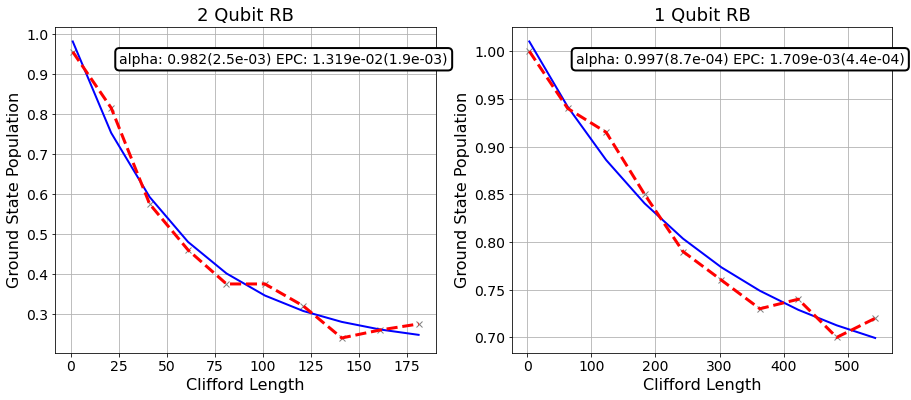

In [13]:
plt.figure(figsize=(15, 6))

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    pattern_ind = i

    # Plot the essence by calling plot_rb_data
    rbfit.plot_rb_data(pattern_ind, ax=ax, add_label=True, show_plt=False)

    # Add title and label
    ax.set_title('%d Qubit RB'%(len(rb_opts['rb_pattern'][i])), fontsize=18)

plt.show()

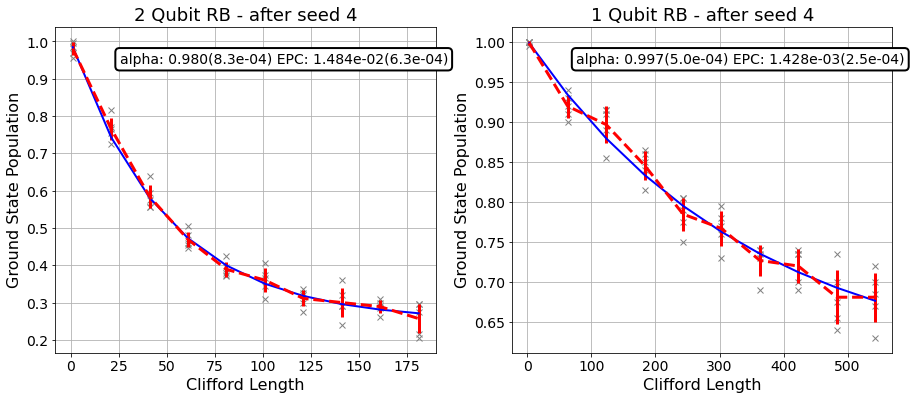

In [14]:
rbfit = rb.fitters.RBFitter(result_list[0], xdata, rb_opts['rb_pattern'])

for seed_num, data in enumerate(result_list):#range(1,len(result_list)):  
    plt.figure(figsize=(15, 6))
    axis = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]
    
    # Add another seed to the data
    rbfit.add_data([data])
    
    for i in range(2):
        pattern_ind = i

        # Plot the essence by calling plot_rb_data
        rbfit.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

        # Add title and label
        axis[i].set_title('%d Qubit RB - after seed %d'%(len(rb_opts['rb_pattern'][i]), seed_num), fontsize=18)
        
    # Display
    display.display(plt.gcf())
    
    # Clear display after each seed and close
    display.clear_output(wait=True)
    time.sleep(1.0)
    plt.close()

In [15]:
shots = 200
result_list = []
transpile_list = []
for rb_seed,rb_circ_seed in enumerate(rb_circs):
    print('Compiling seed %d'%rb_seed)
    rb_circ_transpile = qiskit.transpile(rb_circ_seed, basis_gates=basis_gates)
    print('Simulating seed %d'%rb_seed)
    job = qiskit.execute(rb_circ_transpile, noise_model=noise_model, shots=shots, backend=backend, backend_options={'max_parallel_experiments': 0})
    result_list.append(job.result())
    transpile_list.append(rb_circ_transpile)    
print("Finished Simulating")

Compiling seed 0
Simulating seed 0
Compiling seed 1
Simulating seed 1
Compiling seed 2
Simulating seed 2
Compiling seed 3
Simulating seed 3
Compiling seed 4
Simulating seed 4
Finished Simulating


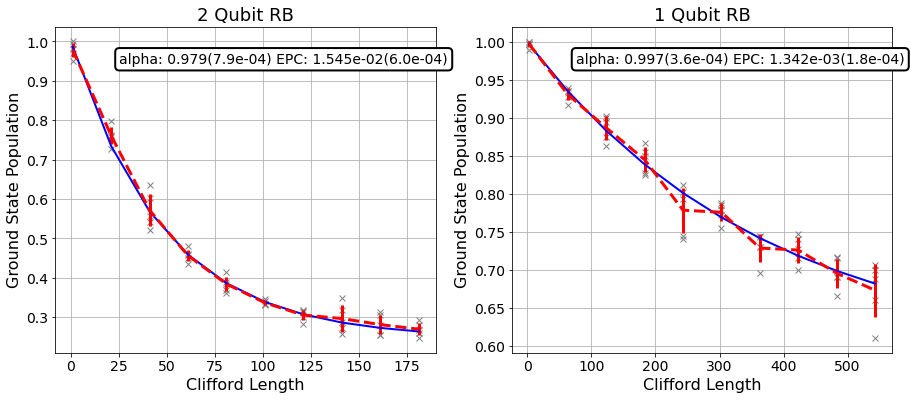

In [16]:
#Add this data to the previous fit
rbfit.add_data(result_list)

#Replot
plt.figure(figsize=(15, 6))

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    pattern_ind = i

    # Plot the essence by calling plot_rb_data
    rbfit.plot_rb_data(pattern_ind, ax=ax, add_label=True, show_plt=False)

    # Add title and label
    ax.set_title('%d Qubit RB'%(len(rb_opts['rb_pattern'][i])), fontsize=18)

plt.show()

In [17]:
#Count the number of single and 2Q gates in the 2Q Cliffords
gates_per_cliff = rb.rb_utils.gates_per_clifford(transpile_list,xdata[0],basis_gates,rb_opts['rb_pattern'][0])
for basis_gate in basis_gates:
    print("Number of %s gates per Clifford: %f "%(basis_gate ,
                                                  np.mean([gates_per_cliff[0][basis_gate],
                                                           gates_per_cliff[2][basis_gate]])))

Number of u1 gates per Clifford: 0.142174 
Number of u2 gates per Clifford: 1.643696 
Number of u3 gates per Clifford: 0.166957 
Number of cx gates per Clifford: 1.468913 


In [18]:
# Error per gate from noise model
epgs_1q = {'u1': 0, 'u2': p1Q/2, 'u3': 2*p1Q/2}
epg_2q = p2Q*3/4
pred_epc = rb.rb_utils.calculate_2q_epc(
    gate_per_cliff=gates_per_cliff,
    epg_2q=epg_2q,
    qubit_pair=[0, 2],
    list_epgs_1q=[epgs_1q, epgs_1q])

# Calculate the predicted epc
print("Predicted 2Q Error per Clifford: %e"%pred_epc)

Predicted 2Q Error per Clifford: 1.565697e-02


In [19]:
rb_opts2 = rb_opts.copy()
rb_opts2['rb_pattern'] = [[0,1]]
rb_opts2['length_multiplier'] = 1
rb_circs2, xdata2 = rb.randomized_benchmarking_seq(**rb_opts2)

noise_model2 = NoiseModel()

#Add T1/T2 noise to the simulation
t1 = 100.
t2 = 80.
gate1Q = 0.1
gate2Q = 0.5
noise_model2.add_all_qubit_quantum_error(thermal_relaxation_error(t1,t2,gate1Q), 'u2')
noise_model2.add_all_qubit_quantum_error(thermal_relaxation_error(t1,t2,2*gate1Q), 'u3')
noise_model2.add_all_qubit_quantum_error(
    thermal_relaxation_error(t1,t2,gate2Q).tensor(thermal_relaxation_error(t1,t2,gate2Q)), 'cx')

In [20]:
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 500
result_list2 = []
transpile_list2 = []
for rb_seed,rb_circ_seed in enumerate(rb_circs2):
    print('Compiling seed %d'%rb_seed)
    rb_circ_transpile = qiskit.transpile(rb_circ_seed, basis_gates=basis_gates)
    print('Simulating seed %d'%rb_seed)
    job = qiskit.execute(rb_circ_transpile, noise_model=noise_model, shots=shots, backend=backend, backend_options={'max_parallel_experiments': 0})
    result_list2.append(job.result())
    transpile_list2.append(rb_circ_transpile)    
print("Finished Simulating")

Compiling seed 0
Simulating seed 0
Compiling seed 1
Simulating seed 1
Compiling seed 2
Simulating seed 2
Compiling seed 3
Simulating seed 3
Compiling seed 4
Simulating seed 4
Finished Simulating


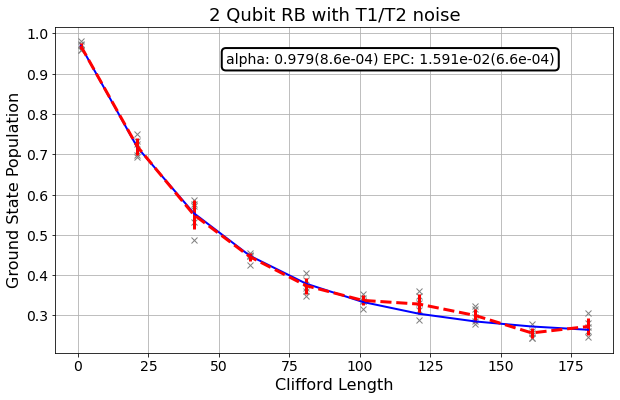

In [21]:
#Create an RBFitter object 
rbfit = rb.RBFitter(result_list2, xdata2, rb_opts2['rb_pattern'])

plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot the essence by calling plot_rb_data
rbfit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)

# Add title and label
ax.set_title('2 Qubit RB with T1/T2 noise', fontsize=18)

plt.show()

In [22]:
#Count the number of single and 2Q gates in the 2Q Cliffords
gates_per_cliff = rb.rb_utils.gates_per_clifford(transpile_list2,xdata[0],basis_gates,rb_opts2['rb_pattern'][0])
for basis_gate in basis_gates:
    print("Number of %s gates per Clifford: %f "%(basis_gate ,
                                                  np.mean([gates_per_cliff[0][basis_gate],
                                                           gates_per_cliff[1][basis_gate]])))

Number of u1 gates per Clifford: 0.119674 
Number of u2 gates per Clifford: 1.655000 
Number of u3 gates per Clifford: 0.181848 
Number of cx gates per Clifford: 1.500652 


In [23]:
# Predicted primitive gate errors from the coherence limit
u2_error = rb.rb_utils.coherence_limit(1,[t1],[t2],gate1Q)
u3_error = rb.rb_utils.coherence_limit(1,[t1],[t2],2*gate1Q)
epg_2q = rb.rb_utils.coherence_limit(2,[t1,t1],[t2,t2],gate2Q)
epgs_1q = {'u1': 0, 'u2': u2_error, 'u3': u3_error}
pred_epc = rb.rb_utils.calculate_2q_epc(
    gate_per_cliff=gates_per_cliff,
    epg_2q=epg_2q,
    qubit_pair=[0, 1],
    list_epgs_1q=[epgs_1q, epgs_1q])

# Calculate the predicted epc
print("Predicted 2Q Error per Clifford: %e"%pred_epc)

Predicted 2Q Error per Clifford: 1.320763e-02


In [24]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright